In [1]:
!export PYTHONPATH='/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/PythonNlpResearch:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Calculations:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Classifiers:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Classifiers/RegEx:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Classifiers/Trees:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Clustering:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/CodeGen:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/CollectionsHelper:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Data:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Data/Chicago:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Data/CoralBleaching:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Data/CoralBleachingWordTagger:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Data/SkinCancerWordTagger:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Data/GlobalWarming:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Data/GlobalWarmingAnnotated:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Data/GoogleNGrams:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning/DeepBeliefNetwork:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning/Examples:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning/Examples/DeepAutoEncoder:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning/Examples/DeepAutoEncoder_MichaelNielsen:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning/MyCode:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning/MyCode/RecursiveAutoEncoder:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning/WordVectors:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/Chicago:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/CoralBleaching:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/GlobalWarming:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/GlobalWarming/Causal:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/GlobalWarming/WordClustering:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/FeatureExtraction/Text:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Frequency:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/LanguageModel:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Results:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Tagging:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/VectorSpace:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/VectorSpace/WordVectors:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/VectorSpace/WordVectors/Word2Vec:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/_Scratch/Sub:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Synonyms:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning/MyCode/:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/MontyLingua:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/CoralBleachingWordTagger/WindowBasedClassifier:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/Tagging:/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/CoralBleachingWordTagger/DeepNN'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo
from pprint import pprint

In [11]:
import sys
sys.path.append("/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/notebooks/Causal Model/src/")
from causal_model_features import CausalModelType, distance_between, is_forward_relation, build_cb_causal_model, build_sc_causal_model
cb_mdl = build_cb_causal_model()
sc_mdl = build_sc_causal_model()

In [3]:
client = pymongo.MongoClient()
db = client.metrics_causal

In [62]:
from Settings import Settings
from window_based_tagger_config import get_config
import dill

settings = Settings()
root_folder = settings.data_directory + "CoralBleaching/Thesis_Dataset/"
rnn_predictions_folder = root_folder + "Predictions/Bi-LSTM-4-SEARN/"

train_fname = rnn_predictions_folder + "essays_train_bi_directional-True_hidden_size-256_merge_mode-sum_num_rnns-2_use_pretrained_embedding-True.dill"
with open(train_fname, "rb") as f:
    pred_tagged_essays_train_cb = dill.load(f)

test_fname = rnn_predictions_folder + "essays_test_bi_directional-True_hidden_size-256_merge_mode-sum_num_rnns-2_use_pretrained_embedding-True.dill"
with open(test_fname, "rb") as f:
    pred_tagged_essays_test_cb = dill.load(f)
    
cb_essays = pred_tagged_essays_train_cb + pred_tagged_essays_test_cb
len(cb_essays)

Results Dir: /Users/simon.hughes/Google Drive/Phd/Results/
Data Dir:    /Users/simon.hughes/Google Drive/Phd/Data/
Root Dir:    /Users/simon.hughes/GitHub/NlpResearch/
Public Data: /Users/simon.hughes/GitHub/NlpResearch/Data/PublicDatasets/


1128

In [63]:
root_folder = settings.data_directory + "SkinCancer/Thesis_Dataset/"
rnn_predictions_folder = root_folder + "Predictions/Bi-LSTM-4-SEARN/"

train_fname = rnn_predictions_folder + "essays_train_bi_directional-True_hidden_size-256_merge_mode-sum_num_rnns-2_use_pretrained_embedding-True.dill"
with open(train_fname, "rb") as f:
    pred_tagged_essays_train_sc = dill.load(f)

test_fname = rnn_predictions_folder + "essays_test_bi_directional-True_hidden_size-256_merge_mode-sum_num_rnns-2_use_pretrained_embedding-True.dill"
with open(test_fname, "rb") as f:
    pred_tagged_essays_test_sc = dill.load(f)
    
sc_essays = pred_tagged_essays_train_sc + pred_tagged_essays_test_sc
len(sc_essays)

1088

In [71]:
e = cb_essays[0]
# for wd, tags in e.sentences:
#     pass
for s in e.sentences:
    for wd, tags in s:
        pass

('.', set())

In [356]:
def get_sentences_per_tag(essays):
    sentbytag = defaultdict(list)
    for essay in essays:
        for sent in essay.sentences:
            tmp = defaultdict(list)
            for wd,tags in sent:
                for t in tags:
                    tmp[t].append(wd)
            for tag, wds in tmp.items():
                sentbytag[tag].append(wds)
    return sentbytag

def get_doc_freq(essays):
    df = defaultdict(int)
    for essay in essays:
        wds_in_e = set()
        for sent in essay.sentences:
            for wd,tags in sent:
                wds_in_e.add(wd)
        for wd in wds_in_e:
            df[wd] += 1
    return df

cb_sent_by_tag = get_sentences_per_tag(cb_essays)
cb_docf = get_doc_freq(cb_essays)

sc_sent_by_tag = get_sentences_per_tag(sc_essays)
sc_docf = get_doc_freq(sc_essays)

In [375]:
def get_crel_stats(sent_by_tag, docf, code_filter, partition):
    dfs = []
    word_spans = []
    unq_sents = set()
    total_sents = 0 # non-unique
    for code in code_filter:
        sents = sent_by_tag[code]
        total_sents += len(sents)
        for sent in sents:
            unq_sents.add(tuple(sent))
            word_spans.append(len(sent))
            for word in sent:
                dfs.append(docf[word])
    
    num_sents = len(unq_sents)
    num_wds = 0
    for sent in unq_sents:
        num_wds += len(sent)
    
    return {
        "Partition": partition,
#         "num_unq_sents": len(unq_sents),
        "num_sents_per_code": total_sents/len(code_filter),
#         "num_wds": num_wds,
        "avg_span": np.mean(word_spans),
        "avg_df": np.mean(dfs)
    }

In [4]:
def __precision__(tp, fp, fn):
    if tp + fp <= 0:
        return 0.0
    return tp / (tp + fp)

def __recall__(tp, fp, fn):
    if tp + fn <= 0:
        return 0.0
    return tp / (tp + fn)

def __f_beta__(r, p, beta):
    if r + p <= 0.0:
        return 0.0
    beta_squared = beta * beta
    #Harmonic mean
    return ((1.0 + beta_squared) * r * p) / (beta_squared * (r + p))

def rpf1a_from_tp_fp_tn_fn(tp, fp, tn, fn):
    r = __recall__(tp, fp, fn)
    p = __precision__(tp, fp, fn)
    f1 = __f_beta__(r, p, 1.0)

    a = (tp + tn) / (tp + fp + tn + fn)
    return (r, p, f1, a)

In [165]:
from collections import defaultdict, OrderedDict

def coll2algo(coll):
    if "RNN" in coll:
        return "Bidirectional RNN"
    if "STACKED" in coll:
        return "Stacked Classifier"
    if "PARSER" in coll:
        return "Shift-Reduce Parser"
    return ""

def coll2algo_shortname(coll):
    if "RNN" in coll:
        return "RNN"
    if "STACKED" in coll:
        return "Stacked"
    if "PARSER" in coll:
        return "Parser"
    return ""

def compute_metrics_for_relations(collection, relns=None):
    rows = list(db[collection].find())
    assert len(rows) == 1
    row = rows[0]
    tally = defaultdict(int)
    for k,val in row.items():
        if "->" in k and (not relns or k in relns):
            for prop in "tp,tn,fp,fn".split(","):
                tally[prop] += val[prop]
                
    (rec, prec, f1, acc) = rpf1a_from_tp_fp_tn_fn(tally["tp"],tally["fp"],tally["tn"],tally["fn"])
    return dict(OrderedDict({
        "algo": coll2algo(collection),
        "recall": rec,
        "precision": prec,
        "f1_score": f1,
        "accuracy": acc
    }))

In [146]:
def round_data(df, places=3):
    df_copy = df.copy()
    fmt_str = "{0:." + str(places) + "f}"
    cols = set([v for v in df_copy.columns.values if "micro_" in v])
    for c in cols:
        df_copy[c] = df[c].apply(lambda d: fmt_str.format(d))  
    return df_copy

## Get All Crels

In [147]:
cb_crels = set()
row = list(db["CR_CB_TAGGING_VD_MOST_COMMON_TAG_RNN"].find())[0]
for k,v in row.items():
    if "->" in k:
        cb_crels.add(k)
len(cb_crels)

86

In [148]:
sc_crels = set()
row = list(db["CR_SC_TAGGING_VD_MOST_COMMON_TAG_RNN"].find())[0]
for k,v in row.items():
    if "->" in k:
        sc_crels.add(k)
len(sc_crels)

49

In [149]:
from causal_model_features import __nodes_between__
__nodes_between__("1", "11", cb_mdl)

-1

In [150]:
def partition_rels(crels):
    val = set()
    inv = set()
    to50 = set()
    adj = set()
    for crel in crels:
        a,b = crel.replace("Causer:","").replace("Result:","").split("->")
        if is_forward_relation(a,b,cb_mdl):
            if b == "50":
                to50.add(crel)
            if __nodes_between__(a,b, cb_mdl) == 1:
                adj.add(crel)
            val.add(crel)
        else:
            inv.add(crel)
    return {
        "valid": val, "invalid": inv, 
        "to 50": to50,
        "adjacent": adj
    }

cb_part = partition_rels(cb_crels)
sc_part = partition_rels(sc_crels)

In [151]:
cb_collections = [
    "CR_CB_TAGGING_VD_MOST_COMMON_TAG_RNN", 
    "CR_CB_STACKED_VD",
    "CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_HYPER_PARAM_VD"
]
test_collections_cb = ["TEST_" + c.replace("HYPER_PARAM_","") for c in cb_collections]
test_collections_sc = [c.replace("_CB","_SC") for c in test_collections_cb]

In [391]:
def analyze_performance_by_partition(part2relations, colls):
    rows_by_parttn = defaultdict(dict)
    for parttn, crels in part2relations.items():
        for coll in colls:
            metrics = compute_metrics_for_relations(coll, crels)
            d = rows_by_parttn[parttn]
            d["Partition"] = parttn
            d[metrics["algo"]] = metrics["f1_score"]
    return pd.DataFrame(rows_by_parttn.values())

df_perf_cb = analyze_performance_by_partition(cb_part, test_collections_cb).round(3)
df_perf_cb

,Partition,Bidirectional RNN,Stacked Classifier,Shift-Reduce Parser
0,valid,0.689,0.717,0.747
1,invalid,0.148,0.242,0.361
2,to 50,0.686,0.725,0.750
3,adjacent,0.779,0.797,0.799


In [392]:
df_perf_sc = analyze_performance_by_partition(sc_part, test_collections_sc).round(3)
df_perf_sc

,Partition,Bidirectional RNN,Stacked Classifier,Shift-Reduce Parser
0,valid,0.805,0.775,0.798
1,invalid,0.640,0.600,0.671
2,to 50,0.808,0.769,0.799
3,adjacent,0.836,0.806,0.844


# Compute NLP Stats

In [397]:
rows = []
for part, crels in cb_part.items():
    rows.append(get_crel_stats(cb_sent_by_tag, cb_docf, crels, part))

df_stats_cb = pd.DataFrame(rows).round(1)
# df_stats_cb

In [398]:
rows = []
for part, crels in sc_part.items():
    rows.append(get_crel_stats(sc_sent_by_tag, sc_docf, crels, part))

df_stats_sc = pd.DataFrame(rows).round(1)
# df_stats_sc

# Merge Both

In [437]:
def df_to_latex_rows(df):
    for i,row in df.iterrows():
#         vals = [f"\\textbf{{ {row.name} }}"]
        vals = [f"{row.name}"]
        for col in df.columns:
            vals.append(str(row[col]))
        print(f"{' & '.join(vals)} \\\\")

In [438]:
m_cb = pd.merge(right=df_stats_cb, left=df_perf_cb, on="Partition").T
m_cb

,0,1,2,3
Partition,valid,invalid,to 50,adjacent
Bidirectional RNN,0.689,0.148,0.686,0.779
Stacked Classifier,0.717,0.242,0.725,0.797
Shift-Reduce Parser,0.747,0.361,0.75,0.799
num_sents_per_code,69.1,4.1,152.8,112.7
avg_span,11.3,11.1,11,11.5
avg_df,544.3,498.9,593,525.8


In [439]:
df_to_latex_rows(m_cb)

Partition & valid & invalid & to 50 & adjacent \\
Bidirectional RNN & 0.689 & 0.148 & 0.686 & 0.779 \\
Stacked Classifier & 0.717 & 0.242 & 0.725 & 0.797 \\
Shift-Reduce Parser & 0.747 & 0.361 & 0.75 & 0.799 \\
num_sents_per_code & 69.1 & 4.1 & 152.8 & 112.7 \\
avg_span & 11.3 & 11.1 & 11.0 & 11.5 \\
avg_df & 544.3 & 498.9 & 593.0 & 525.8 \\


In [441]:
m_sc = pd.merge(right=df_stats_sc, left=df_perf_sc, on="Partition").T
m_sc

,0,1,2,3
Partition,valid,invalid,to 50,adjacent
Bidirectional RNN,0.805,0.64,0.808,0.836
Stacked Classifier,0.775,0.6,0.769,0.806
Shift-Reduce Parser,0.798,0.671,0.799,0.844
num_sents_per_code,245.7,17,391.6,310.6
avg_span,10.4,7,10.5,9.9
avg_df,603.2,462.5,637.5,547.6


In [442]:
df_to_latex_rows(m_sc)

Partition & valid & invalid & to 50 & adjacent \\
Bidirectional RNN & 0.805 & 0.64 & 0.808 & 0.836 \\
Stacked Classifier & 0.775 & 0.6 & 0.769 & 0.806 \\
Shift-Reduce Parser & 0.798 & 0.671 & 0.799 & 0.844 \\
num_sents_per_code & 245.7 & 17.0 & 391.6 & 310.6 \\
avg_span & 10.4 & 7.0 & 10.5 & 9.9 \\
avg_df & 603.2 & 462.5 & 637.5 & 547.6 \\


# Get Performance Across All Relations

In [381]:
# rows = []
# for c in test_collections_cb:
#     d = compute_metrics_for_relations(c)
#     rows.append(d)
# df_cb = pd.DataFrame(rows)
# df_cb

In [382]:
# rows = []
# for c in test_collections_sc:
#     d = compute_metrics_for_relations(c)
#     rows.append(d)
# df_sc = pd.DataFrame(rows)
# df_sc

## Essay Crel Statistics

In [218]:
def print_table_of_crels(collections, relns=None):    
    metrics = defaultdict(dict)
    for coll in collections:
        rows = list(db[coll].find())
        assert len(rows) == 1, coll
        row = rows[0]
        for k,val in row.items():
            if "->" in k:
                metrics[k]["Crel"] = k
                metrics[k][coll2algo_shortname(coll)] = val["f1_score"]                
    df_perf = pd.DataFrame(metrics.values()).sort_values("Crel")
    df_perf["code1"] = df_perf["Crel"].apply(lambda s: int(s.replace("Causer:","").replace("Result:","").split("->")[0].replace("b","")) )
    df_perf["code2"] = df_perf["Crel"].apply(lambda s: int(s.replace("Causer:","").replace("Result:","").split("->")[1].replace("b","")) )
    df_perf = df_perf.sort_values(["code1","code2"])
    del df_perf["code1"]
    del df_perf["code2"]
    return df_perf

In [383]:
df_perf_cb_latex = print_table_of_crels(test_collections_cb)


In [220]:
tpls = list(df_perf_cb.itertuples())
size = len(tpls)//2
for tpl, tpl2 in zip(tpls[:size],tpls[size:]):
    crel = tpl.Crel.replace("->","\\textrightarrow ").replace("Causer:","").replace("Result:","")
    crel2 = tpl2.Crel.replace("->","\\textrightarrow ").replace("Causer:","").replace("Result:","")
    print(f"{crel}\t& {tpl.RNN:.3f} & {tpl.Stacked:.3f} & {tpl.Parser:.3f} & {crel2}\t& {tpl2.RNN:.3f} & {tpl2.Stacked:.3f} & {tpl2.Parser:.3f} \\\\")

1\textrightarrow 2	& 0.840 & 0.667 & 0.840 & 5\textrightarrow 50	& 0.667 & 0.308 & 0.667 \\
1\textrightarrow 3	& 0.651 & 0.591 & 0.682 & 5b\textrightarrow 50	& 0.000 & 0.000 & 0.250 \\
1\textrightarrow 4	& 0.000 & 0.000 & 0.000 & 6\textrightarrow 5	& 0.000 & 0.000 & 1.000 \\
1\textrightarrow 5	& 0.000 & 0.000 & 0.500 & 6\textrightarrow 5b	& 0.000 & 0.000 & 0.000 \\
1\textrightarrow 6	& 0.000 & 0.000 & 0.000 & 6\textrightarrow 7	& 0.844 & 0.863 & 0.894 \\
1\textrightarrow 7	& 0.000 & 0.000 & 0.333 & 6\textrightarrow 14	& 0.333 & 0.444 & 0.519 \\
1\textrightarrow 11	& 0.000 & 0.000 & 0.000 & 6\textrightarrow 50	& 0.455 & 0.737 & 0.750 \\
1\textrightarrow 13	& 0.000 & 0.000 & 0.000 & 7\textrightarrow 1	& 0.000 & 0.000 & 0.000 \\
1\textrightarrow 14	& 0.000 & 0.000 & 0.000 & 7\textrightarrow 4	& 0.000 & 0.000 & 0.000 \\
1\textrightarrow 50	& 0.809 & 0.788 & 0.822 & 7\textrightarrow 5	& 0.000 & 0.000 & 0.000 \\
2\textrightarrow 1	& 0.000 & 0.000 & 0.000 & 7\textrightarrow 5b	& 0.000 & 0.000

In [384]:
df_perf_sc_latex = print_table_of_crels(test_collections_sc)


In [385]:
len(df_perf_sc)

49

In [386]:
offset = 5
tpls = list(df_perf_sc.itertuples())
tpls = tpls + [tpls[-1]]
size = (len(tpls)//2)
for tpl, tpl2 in zip(tpls[:size],tpls[size:]):
    crel = tpl.Crel.replace("->","\\textrightarrow ").replace("Causer:","").replace("Result:","")
    crel2 = tpl2.Crel.replace("->","\\textrightarrow ").replace("Causer:","").replace("Result:","")
    print(f"{crel}\t& {tpl.RNN:.3f} & {tpl.Stacked:.3f} & {tpl.Parser:.3f} & {crel2}\t& {tpl2.RNN:.3f} & {tpl2.Stacked:.3f} & {tpl2.Parser:.3f} \\\\")

1\textrightarrow 2	& 0.842 & 0.812 & 0.855 & 5\textrightarrow 4	& 0.372 & 0.000 & 0.400 \\
1\textrightarrow 3	& 0.812 & 0.692 & 0.800 & 5\textrightarrow 5	& 0.000 & 0.000 & 0.000 \\
1\textrightarrow 4	& 0.000 & 0.000 & 0.000 & 5\textrightarrow 6	& 0.878 & 0.881 & 0.867 \\
1\textrightarrow 5	& 0.667 & 0.000 & 0.000 & 5\textrightarrow 12	& 0.000 & 0.000 & 0.000 \\
1\textrightarrow 50	& 0.747 & 0.725 & 0.815 & 5\textrightarrow 50	& 0.852 & 0.843 & 0.847 \\
2\textrightarrow 1	& 0.000 & 0.000 & 0.000 & 6\textrightarrow 3	& 0.000 & 0.000 & 0.000 \\
2\textrightarrow 2	& 0.000 & 0.000 & 0.000 & 6\textrightarrow 4	& 0.000 & 0.000 & 0.000 \\
2\textrightarrow 3	& 0.804 & 0.757 & 0.785 & 6\textrightarrow 5	& 0.000 & 0.000 & 0.500 \\
2\textrightarrow 4	& 0.500 & 0.533 & 0.267 & 6\textrightarrow 50	& 0.912 & 0.876 & 0.876 \\
2\textrightarrow 5	& 0.605 & 0.333 & 0.357 & 11\textrightarrow 3	& 0.000 & 0.000 & 0.000 \\
2\textrightarrow 6	& 0.000 & 0.000 & 0.000 & 11\textrightarrow 4	& 0.000 & 0.000 & 0.

### Plot F1 By Crel Freq

In [285]:
def get_f1s_freq(collection):
    rows = list(db[collection].find())
    assert len(rows) == 1, coll
    row = rows[0]
    f1s = []
    freqs = []
    metrics
    for k,val in row.items():
        if "->" in k:
            f1s.append(val["f1_score"])
            freqs.append(val["num_codes"])
#     return f1s, np.log1p(freqs)
    return f1s, freqs

In [286]:
test_collections_cb

['TEST_CR_CB_TAGGING_VD_MOST_COMMON_TAG_RNN',
 'TEST_CR_CB_STACKED_VD',
 'TEST_CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_VD']

In [287]:
def set_tick_font_size(ax, fs):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fs) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fs) 

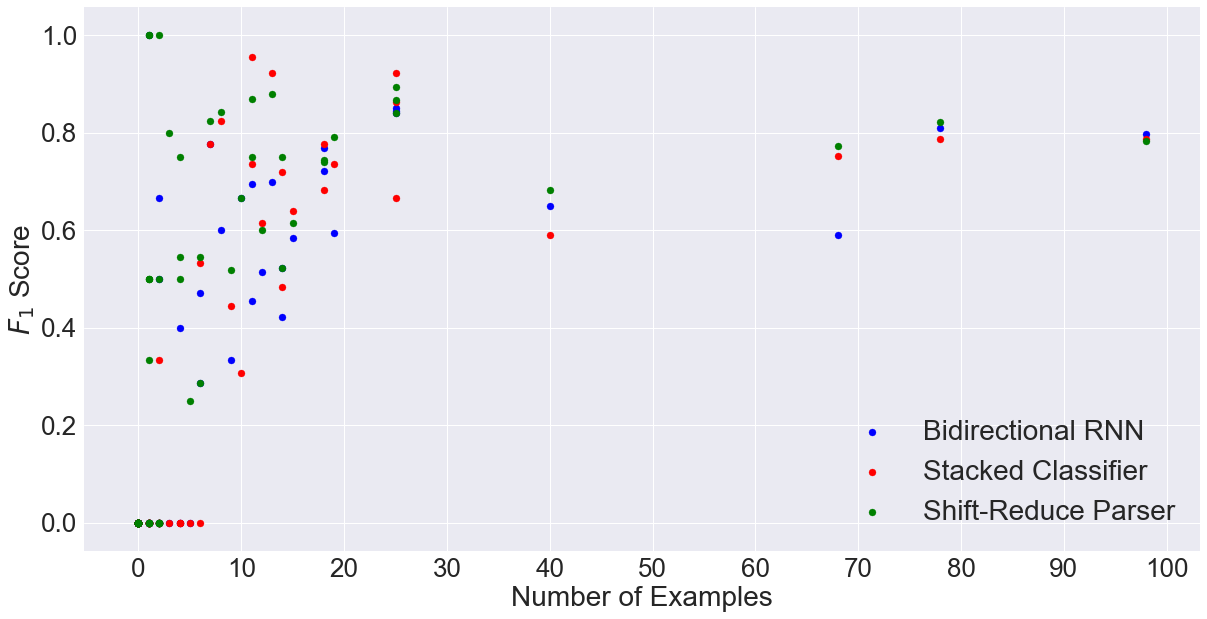

In [318]:
import seaborn as sns
import matplotlib.ticker as plticker

FONT_SIZE = 28

rnn_f1, rnn_freq = get_f1s_freq("TEST_CR_CB_TAGGING_VD_MOST_COMMON_TAG_RNN")
stacked_f1, stacked_freq = get_f1s_freq("TEST_CR_CB_STACKED_VD")
parser_f1, parser_freq = get_f1s_freq("TEST_CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_VD")

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
ax = fig.add_subplot(111)

# set x axis tick interval
loc = plticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

ax.set_ylabel('$F_1$ Score',            fontsize=FONT_SIZE)
ax.set_xlabel('Number of Examples',  fontsize=FONT_SIZE)
set_tick_font_size(ax, FONT_SIZE-2)

ax.scatter(rnn_freq,     rnn_f1,     c='b', marker="o", label='Bidirectional RNN')
ax.scatter(stacked_freq, stacked_f1, c='r', marker="o", label='Stacked Classifier')
ax.scatter(parser_freq,  parser_f1,  c='g', marker="o", label='Shift-Reduce Parser')
# ax.set_facecolor('1') # set background white

plt.legend(loc='lower right', fontsize=FONT_SIZE)

images_folder = "/Users/simon.hughes/BitBucket/dissertation/Dissertation/images"
fname = f"{images_folder}/rq2_f1_per_crel_freq_cb.png"
plt.savefig(fname, bbox_inches = 'tight', pad_inches = 0) # remove unneccessary whitespace

## Number of 0 F1 Scores

In [298]:
len([i for i in parser_f1 if i == 0.0])

50

In [299]:
len([i for i in rnn_f1 if i == 0.0])

59

In [300]:
len([i for i in stacked_f1 if i == 0.0])

63

## Skin Cancer

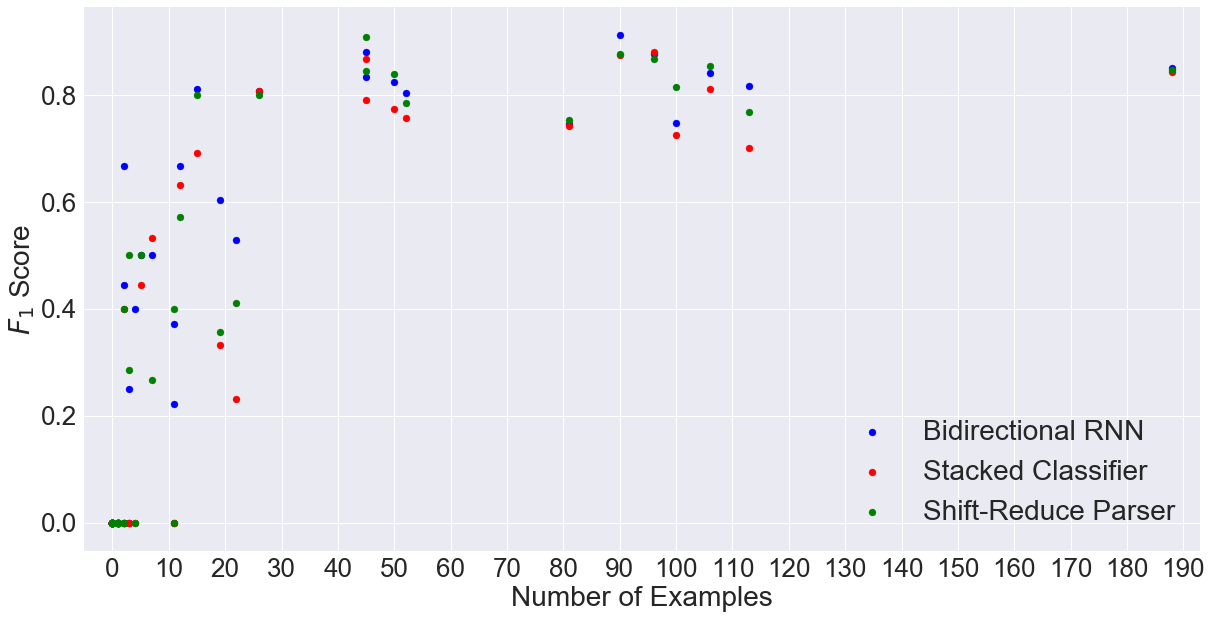

In [317]:
import seaborn as sns
import matplotlib.ticker as plticker

FONT_SIZE = 28

rnn_f1, rnn_freq = get_f1s_freq("TEST_CR_SC_TAGGING_VD_MOST_COMMON_TAG_RNN")
stacked_f1, stacked_freq = get_f1s_freq("TEST_CR_SC_STACKED_VD")
parser_f1, parser_freq = get_f1s_freq("TEST_CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_VD")

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
ax = fig.add_subplot(111)

# set x axis tick interval
loc = plticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

ax.set_ylabel('$F_1$ Score',            fontsize=FONT_SIZE)
ax.set_xlabel('Number of Examples',  fontsize=FONT_SIZE)

set_tick_font_size(ax, FONT_SIZE-2)

ax.scatter(rnn_freq,     rnn_f1,     c='b', marker="o", label='Bidirectional RNN')
ax.scatter(stacked_freq, stacked_f1, c='r', marker="o", label='Stacked Classifier')
ax.scatter(parser_freq,  parser_f1,  c='g', marker="o", label='Shift-Reduce Parser')

ax.set_xlim([-5, max(parser_freq)+5 ])
# ax.set_facecolor('1') # set background white

plt.legend(loc='lower right', fontsize=FONT_SIZE);

images_folder = "/Users/simon.hughes/BitBucket/dissertation/Dissertation/images"
fname = f"{images_folder}/rq2_f1_per_crel_freq_sc.png"
plt.savefig(fname, bbox_inches = 'tight', pad_inches = 0) # remove unneccessary whitespace

## Compute Pearson's Correlation Coefficient

In [342]:
from scipy import stats

rnn_f1, rnn_freq = get_f1s_freq("TEST_CR_CB_TAGGING_VD_MOST_COMMON_TAG_RNN")
stacked_f1, stacked_freq = get_f1s_freq("TEST_CR_CB_STACKED_VD")
parser_f1, parser_freq = get_f1s_freq("TEST_CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_VD")

f1s = rnn_f1 + stacked_f1 + parser_f1
freqs = rnn_freq + stacked_freq + parser_freq

coeff, pval = stats.pearsonr(f1s, freqs)
coeff, pval

(0.596331506847296, 3.089196020877448e-26)

In [341]:
from scipy import stats

rnn_f1, rnn_freq = get_f1s_freq("TEST_CR_SC_TAGGING_VD_MOST_COMMON_TAG_RNN")
stacked_f1, stacked_freq = get_f1s_freq("TEST_CR_SC_STACKED_VD")
parser_f1, parser_freq = get_f1s_freq("TEST_CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_VD")

f1s = rnn_f1 + stacked_f1 + parser_f1
freqs = rnn_freq + stacked_freq + parser_freq

coeff, pval = stats.pearsonr(f1s, freqs)
coeff, pval

(0.7570958626597188, 1.3517146239087752e-28)

## Group Performance By Frequency

In [330]:
def partition_codes_by_freq(collection):
    rows = list(db[collection].find())
    row = rows[0]

    freq2crels = defaultdict(set)
    for crel,val in row.items():
        if "->" not in crel:
            continue
        ncodes = val["num_codes"]
        
        if ncodes <= 10:
            freq2crels["0-10"].add(crel)
        if ncodes <= 25:
            freq2crels["11-25"].add(crel)
        elif ncodes <= 50:
            freq2crels["26-50"].add(crel)
        elif ncodes <= 75:
            freq2crels["51-75"].add(crel)
        else:
            freq2crels["51-"].add(crel)
    return freq2crels

In [331]:
freq2crels_cb = partition_codes_by_freq("TEST_CR_CB_TAGGING_VD_MOST_COMMON_TAG_RNN")
analyze_performance_by_partition(freq2crels_cb, test_collections_cb)

,Partition,Bidirectional RNN,Stacked Classifier,Shift-Reduce Parser
0,0-10,0.415584,0.352113,0.513043
1,11-25,0.619621,0.657343,0.687045
2,26-50,0.650602,0.590909,0.682353
3,51-,0.803279,0.787879,0.801136
4,51-75,0.590909,0.752000,0.773723


In [333]:
freq2crels_sc = partition_codes_by_freq("TEST_CR_SC_TAGGING_VD_MOST_COMMON_TAG_RNN")
analyze_performance_by_partition(freq2crels_sc, test_collections_cb)

,Partition,Bidirectional RNN,Stacked Classifier,Shift-Reduce Parser
0,0-10,0.666667,0.560000,0.603175
1,11-25,0.614583,0.603175,0.653465
2,26-50,0.796296,0.849057,0.810345
3,51-,0.706173,0.735135,0.792176
4,51-75,0.583333,0.640000,0.615385
